In [32]:
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2
%matplotlib inline 


import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from scipy import stats
from scipy.interpolate import interp1d,interp2d
from scipy.optimize import least_squares
import pandas as pd
import sys
import pickle
from tqdm import tqdm
from importlib import reload



# Import code
sys.path.insert(0, './../../../DataAndScripts/unstructured_scripts/')
import functions_optimal as fun
import functions_dynamics as fun_dyn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:

#######################################
folder_data='./../../../DataAndScripts/experimental_data/'
#######################################

data_monkeys=np.loadtxt(folder_data+'Monkeys_with_trials.txt');
data_mice=np.loadtxt(folder_data+'Mice_with_trials.txt');

data_both_species=[data_mice,data_monkeys]
species=['Mice','Monkeys']

dataset_both_species,Con_both_species,nCon_both_species,normalization_both_species=[],[],[],[]
for idx_species in range(2):
    dataset,Con,nCon=fun.build_dataset(data_both_species[idx_species])
    normalization=1.0;#np.mean(dataset[0,:,0])
    dataset_both_species=dataset_both_species+[dataset]
    Con_both_species=Con_both_species+[Con]
    nCon_both_species=nCon_both_species+[nCon]
    normalization_both_species=normalization_both_species+[normalization]

# Load best fit params from the previous notebook 

In [35]:
with open('./best_fit/Model_Fit_Separately_UntructModel-Best.pkl', 'rb') as handle:
    best_separately=pickle.load(handle)

# Choose the species 

In [36]:
idx_species=0
print('You are running ' +species[idx_species])

best_inputs= best_separately['best_input_'+species[idx_species]]
best_param = best_separately['best_params_'+species[idx_species]]


You are running Mice


# Simulation parameters

In [38]:

# parameters characterizing the relative strength of synaptic connections
g_E=best_param[0]; g_I=best_param[1];beta=10**best_param[2]; 

# average number of E connections per neuron (I connections are 1/4 of that)
K=500; 

# ratio between mean and standard deviation of the opsin expression
sigma_Lambda_over_Lambda=10**best_param[4]; 

# CV_K
CV_K=10**best_param[3]

# Synaptic efficacy in Volts
J=10**best_param[5]; 

#  Laser intensity that fits the data
L=[0., 10**best_inputs[-1]]; 

# FF inputs
r_X=10**best_inputs[0:-1]




In [39]:
reload(fun)
# probability of connection between cells. 
p=0.1

# Presynaptic population has mean rate r_X, Gaussianly distributed with std=0.2* r_X
sigma_X_over_r_X=0.2

# mean opsin expression in Volt
Lambda=1*10**-3; 
sigma_Lambda=sigma_Lambda_over_Lambda*Lambda

# Compute W_{AB} starting from the parameters defined above

# Gain of Excitatory and inhibitory cells and I cells
G_E,G_I=1.0,2.0 

w_EE=1;w_IE=w_EE/beta;
w_EI=g_E*w_EE;w_II=g_I*w_IE;
w_EX,w_IX=(G_I*fun_dyn.gamma*g_E-G_E)*w_EE,(G_I*fun_dyn.gamma*g_I-G_E)*w_IE; 
w_X=np.asarray([w_EX,w_IX]);
w=np.zeros((2,2));
w[0,:]=w_EE,-w_EI
w[1,:]=w_IE,-w_II


# Obtain the LIF nonlinearity

In [40]:
# Input noise, determine how smooth the single neuron transfer function is 
sigma_t=0.01;

# Refractory period
tau_rp=0.002; 


#'''
mu_tab_max=10.0;
mu_tab=np.linspace(-mu_tab_max,mu_tab_max,200000)
mu_tab=np.concatenate(([-10000],mu_tab))
mu_tab=np.concatenate((mu_tab,[10000]))

phi_tab_E,phi_tab_I=mu_tab*0,mu_tab*0;
for idx in range(len(phi_tab_E)):
    phi_tab_E[idx]=fun_dyn.comp_phi_tab(mu_tab[idx],fun_dyn.tau_E,tau_rp,sigma_t)
    phi_tab_I[idx]=fun_dyn.comp_phi_tab(mu_tab[idx],fun_dyn.tau_I,tau_rp,sigma_t)

phi_int_E=interp1d(mu_tab, phi_tab_E, kind='linear')  
phi_int_I=interp1d(mu_tab, phi_tab_I, kind='linear')
#'''

# Generate quenched disorder

In [41]:

M,mu_X_over_r_X_tau,Lambda_i,N_E,N_I=fun_dyn.Generate_quenched_disorder(CV_K,J,K,w,w_X,p,Lambda,sigma_Lambda)


# Computing and saving network response

In [42]:

# Time in units of E time constant
Tmax_over_tau_E=200;

T=np.arange(0,Tmax_over_tau_E*fun_dyn.tau_E,fun_dyn.tau_I/3);

mask_time=T>(10*fun_dyn.tau_E)
RATES=-1*np.ones((len(r_X),len(L),N_E+N_I))
DYNA=-1*np.ones((len(r_X),len(L),N_E+N_I,len(T)))
MUS=-1*np.ones((len(r_X),len(L),N_E+N_I))
Lambda_i_L=1./tau_rp*np.ones((len(r_X),len(L),N_E+N_I))
MFT_SOL_R=np.ones((len(r_X),len(L),10))
MFT_SOL_M=np.ones((len(r_X),len(L),10))
Phi=[phi_int_E,phi_int_I];
for idx_r_X in tqdm(range(len(r_X))):
    for idx_L in range(len(L)):
        r_X_local,L_local=r_X[idx_r_X],L[idx_L];
        DYNA[idx_r_X,idx_L,:,:], MUS[idx_r_X,idx_L,:],Lambda_i_L[idx_r_X,idx_L,:]=fun_dyn.High_dimensional_dynamics(T,L_local,r_X_local,M,mu_X_over_r_X_tau,Lambda_i,N_E,N_I,phi_int_E,phi_int_I);
        RATES[idx_r_X,idx_L,:]=np.mean(DYNA[idx_r_X,idx_L,:,mask_time],axis=0)

    Base_Sim=RATES[idx_r_X,0,:]
    Delta_Sim=RATES[idx_r_X,idx_L,:]-RATES[idx_r_X,0,:]

    moments_of_r_sim=np.zeros(5)
    moments_of_r_sim[0]=np.mean(Base_Sim)
    moments_of_r_sim[1]=np.mean(Delta_Sim)
    moments_of_r_sim[2]=np.std(Base_Sim)
    moments_of_r_sim[3]=np.std(Delta_Sim)
    moments_of_r_sim[4]=np.cov(Base_Sim,Delta_Sim)[0,1]


100%|██████████| 7/7 [03:04<00:00, 26.31s/it]


# Save single cell rate


In [8]:
# np.save('RATES_unstructured'++species[idx_species],RATES)


# Look at the dynamics of the simulations

0.00512
0.00592
0.0064
0.00672
0.00688
0.00784
0.00768


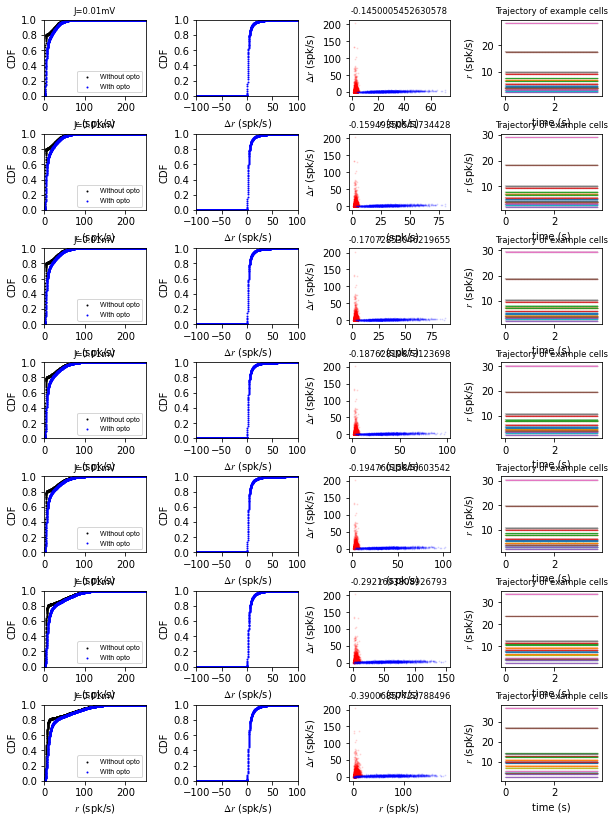

In [43]:
bin_edges=np.arange(0,1./tau_rp,.1)
spacings=np.diff(bin_edges)[0];
bin_means=0.5*(bin_edges[0:-1]+bin_edges[1::])
bin_edges_Delta=np.arange(-1./tau_rp,1./tau_rp,.1)
spacings_Delta=np.diff(bin_edges)[0];
bin_means_Delta=0.5*(bin_edges_Delta[0:-1]+bin_edges_Delta[1::])

fig, axs = plt.subplots(len(r_X),4, figsize=(2.5*4,2.0*len(r_X)), facecolor='w', edgecolor='k')#,sharey='row')#,sharex=True)
fig.subplots_adjust(hspace = .5, wspace=.5)
area=1.0;linethicknes=1.0;
axs = axs.ravel()
font = {'family' : 'normal','weight' : 'normal','size'   : 7, 'family':'serif','serif':['Arial']}
mpl.rc('font', **font)
mpl.rcParams['lines.linewidth'] =linethicknes
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rcParams['pdf.fonttype'] = 42

idx_r_X=0
mask_active_cells=(RATES[idx_r_X,1,:]>=0)|(RATES[idx_r_X,0,:]>=0)
for idx_r_X in np.arange(1,len(r_X),1):
    mask_active_cells=mask_active_cells|(RATES[idx_r_X,1,:]>=0)|(RATES[idx_r_X,0,:]>=0)

for idx_r_X in range(len(r_X)):
    

    color=['k','b',];
    label=['Without opto','With opto']
    for idx_L in range(len(L)):
        #hist, bin_edges=np.histogram(RATES[idx_r_X,idx_L,0:N_E],bin_edges)#,normed=True)
        hist, bin_edges=np.histogram(RATES[idx_r_X,idx_L,mask_active_cells],bin_edges)#,normed=True)
        bin_mean=0.5*(bin_edges[0:-1]+bin_edges[1::])
        spacings=np.diff(bin_edges)[0];
        hist=hist/np.sum(hist*spacings)
        axs[idx_r_X*4+0].scatter(bin_mean,np.cumsum(spacings*hist),c=color[idx_L],s=area,label=label[idx_L])

        
    Delta_Sim=RATES[idx_r_X,1,mask_active_cells]-RATES[idx_r_X,0,mask_active_cells]
    print(len(Delta_Sim[Delta_Sim<0])/len(Delta_Sim))
    
    hist_Delta, bin_edges_Delta=np.histogram(Delta_Sim,bin_edges_Delta,normed=True)
    CDF_Resp_Delta=np.cumsum(hist_Delta*spacings_Delta)
    axs[idx_r_X*4+1].scatter(bin_means_Delta,CDF_Resp_Delta,c='b',s=area);


    #axs[idx_r_X*4+2].scatter(RATES[idx_r_X,0,maks_cells],RATES[idx_r_X,1,maks_cells]-RATES[idx_r_X,0,maks_cells],c='b',s=1,alpha=0.3);
    idx_cells=np.where(np.arange(len(Lambda_i))<N_E)
    axs[idx_r_X*4+2].scatter(RATES[idx_r_X,0,idx_cells],RATES[idx_r_X,1,idx_cells]-RATES[idx_r_X,0,idx_cells],c='r',s=1,alpha=0.1);
    idx_cells=np.where(np.arange(len(Lambda_i))>N_E)
    axs[idx_r_X*4+2].scatter(RATES[idx_r_X,0,idx_cells],RATES[idx_r_X,1,idx_cells]-RATES[idx_r_X,0,idx_cells],c='b',s=1,alpha=0.1);

    cov=np.cov(RATES[idx_r_X,0,mask_active_cells],RATES[idx_r_X,1,mask_active_cells]-RATES[idx_r_X,0,mask_active_cells])
    axs[idx_r_X*4+2].set_title(cov[0,1]/cov[1,1])


    for idx_cell in range(17):
        axs[idx_r_X*4+3].plot(T[mask_time]-T[mask_time][0],DYNA[idx_r_X,1,idx_cell,mask_time],marker='o',markersize=0.1,alpha=0.5)

    axs[idx_r_X*4+0].axis([0,250,.0,1.])
    axs[idx_r_X*4+0].legend(loc='lower right')
    axs[idx_r_X*4+1].axis([-100,100,0,1.])
    axs[idx_r_X*4+0].set_title('J=%.2fmV'%(J*10**3))
    axs[idx_r_X*4+0].set_ylabel('CDF')
    axs[idx_r_X*4+1].set_ylabel('CDF')
    axs[idx_r_X*4+0].set_xlabel('$r$ (spk/s)')
    axs[idx_r_X*4+1].set_xlabel('$\Delta r$ (spk/s)')
    axs[idx_r_X*4+2].set_ylabel('$\Delta r$ (spk/s)')
    axs[idx_r_X*4+2].set_xlabel('$r$ (spk/s)')
    axs[idx_r_X*4+3].set_ylabel('$r$ (spk/s)')
    axs[idx_r_X*4+3].set_xlabel('time (s)')
    axs[idx_r_X*4+3].set_title('Trajectory of example cells')

